# Cumulative Loss

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from IPython.display import clear_output
import ipywidgets as widgets
import os
import math

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)

In [4]:
dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
dirs = np.sort(dirs)
wFolder = widgets.Dropdown(
    options=dict(zip(dirs,dirs)),
    description='Experiment:',
)
display(wFolder)

Dropdown(description='Experiment:', options={'.ipynb_checkpoints': '.ipynb_checkpoints', 'examples': 'examples…

In [5]:
experimentFolder = wFolder.value
print(experimentFolder)

test


In [6]:
nodesAmount = 0
dirs = [d for d in os.listdir(experimentFolder) if os.path.isdir(os.path.join(experimentFolder,d))]
for d in dirs:
    if 'worker' in d:
        nodesAmount += 1
print("Learners amount is ", str(nodesAmount))

Learners amount is  3


## Mean Cumulative Loss Aligned by Amount of Examples Seen

In [7]:
displayStep = 10
# should be larger or equal to displayStep or it will just record same image several times
recordStep = 10
recordUnique = False
displayDiagonal = False

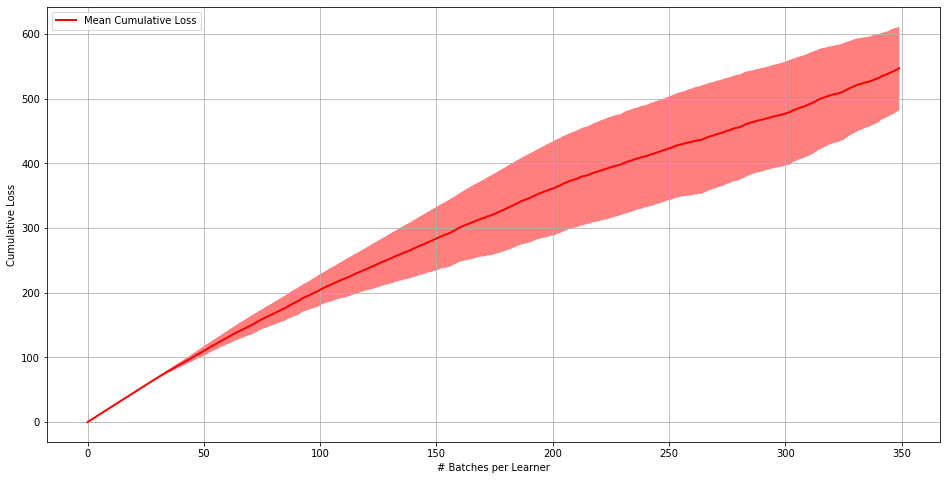

In [ ]:
files = []
losses = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    losses.append([0])
t = [0]
commonStep = 0

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        elif line and line[0] != 'T':
            losses[i].append(losses[i][-1] + float(line[:-1].split('\t\t')[1]))
    currentStep = min([len(l) for l in losses])
    if currentStep > commonStep:
        commonStep = currentStep
        if commonStep % displayStep == 0:
            clear_output(wait=True)
            cutLosses = [l[0:commonStep] for l in losses]
            mu = np.array(cutLosses).mean(axis=0)
            sigma = np.array(cutLosses).std(axis=0)
            fig = plt.figure()
            if displayDiagonal:
                plt.plot(t, t, lw=2, color='blue', ls = 'dashed')
            plt.plot(t, mu, lw=2, label='Mean Cumulative Loss', color='red')
            plt.fill_between(t, mu+sigma, mu-sigma, facecolor='red', alpha=0.5)
            plt.legend(loc='upper left')
            plt.xlabel("# Batches per Learner")
            plt.ylabel("Cumulative Loss")
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if commonStep % recordStep == 0:
            if recordUnique:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_loss' + str(commonStep) + '.png'), dpi=100)
            else:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_loss.png'), dpi=100) 

In [ ]:
for file in files:
    file.close()

## Cumulative Loss (Different from Optimized) Aligned by Amount of Examples

In order to build cumulative loss development for the loss that was not optimized. For example, epsilon-sensitive loss for regression.

In [ ]:
def displayLoss(prediction, label, name, **argv):
    if name == 'epsilon_sensitive':
        if len(label) == 1 and len(prediction) == 1:
            if abs(label[0] - prediction[0]) > argv['epsilon']:
                return abs(label[0] - prediction[0])
            else:
                return 0
    elif name == 'squared':
        if len(label) == 1 and len(prediction) == 1:                
            return (label[0] - prediction[0])**2
    else:
        print("Not known loss function, please define it first.")
        return 0

In [44]:
displayStep = 100
# should be larger or equal to displayStep or it will just record same image several times
recordStep = 100
recordUnique = False
lossF = 'squared'
displayDiagonal = False

In [ ]:
files = []
cumDisplayLosses = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "predictions.txt"), "r"))
    cumDisplayLosses.append([0])
t = [0]

commonStep = 0

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        elif line and line[0]!= 'T':
            pred = [float(x) for x in line[:-1].split('\t\t')[1].split(',')]
            label = [float(x) for x in line[:-1].split('\t\t')[2].split(',')]
            cumDisplayLosses[i].append(cumDisplayLosses[i][-1] + displayLoss(pred, label, lossF, epsilon = 0.001))
    currentStep = min([len(a) for a in cumDisplayLosses])
    if currentStep > commonStep:
        commonStep = currentStep
        if commonStep % displayStep == 0:
            clear_output(wait=True)
            cutDisplayLosses = [a[1:commonStep] for a in cumDisplayLosses]
            mu = np.array(cutDisplayLosses).mean(axis=0)
            sigma = np.array(cutDisplayLosses).std(axis=0)
            fig = plt.figure()
            if displayDiagonal:
                plt.plot(t, t, lw=2, color='blue', ls = 'dashed')
            plt.plot(t, mu, lw=2, label='Mean Cumulative ' + lossF + ' Loss', color='red')
            plt.fill_between(t, mu+sigma, mu-sigma, facecolor='red', alpha=0.5)
            plt.xlabel("# Examples")
            plt.ylabel("Cumulative Loss")
            plt.legend(loc='upper left')
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if commonStep % recordStep == 0:
            if recordUnique:
                fig.savefig(os.path.join(experimentFolder, 
                                         'cumulative_' + lossF + '_loss' + str(commonStep) + '.png'), dpi=100)
            else:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_' + lossF + '_loss.png'), dpi=100)

In [ ]:
for file in files:
    file.close()

## Cumulative Loss Aligned by Time

In [32]:
# setup of the plots saving
displayStep = 1
recordStep = 1
recordUnique = False
uniqueImageCounter = 0
# draw a point for every second of experiment time
frequencyStep = 2
displaySync = True

In [33]:
# get zero timestamp, i.e., beginning of the experiment
expSummary = open(os.path.join(experimentFolder,"summary.txt")).read()
for l in expSummary.split("\n"):
    if "Start" in l:
        startTimestamp = float(l.split("\t")[-1][:-1])
        break

In [34]:
files = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    
if displaySync:
    syncFile = open(os.path.join(experimentFolder, "coordinator", "communication", "send_model.txt"), "r")

In [ ]:
plot = [0]
syncPoints = []
change = False
while True:
    for f in files:
        where = f.tell()
        line = f.readline()
        if line and line[0]!= 'T':
            change = True
            parsedLine = line[:-1].split("\t\t")
            lineTimestamp = float(parsedLine[0])
            # identify to which point in time this line will go
            xPoint = math.ceil((lineTimestamp - startTimestamp) / frequencyStep)
            loss = float(parsedLine[1])
            if len(plot) < xPoint:
                for i in range(xPoint - len(plot)):
                    plot.append(plot[-1])
            for i in range(len(plot) - xPoint + xPoint, xPoint + 1, 1):
                plot[i - 1] += loss
    if displaySync:
        where = syncFile.tell()
        line = syncFile.readline()
        if line and line[0]!= 'T':
            change = True
            parsedLine = line[:-1].split("\t\t")
            lineTimestamp = float(parsedLine[0])
            # if model was sent only to one learner it is not a synchronization
            if parsedLine[2].count(".") > 1:
                syncPoints.append(math.ceil((lineTimestamp - startTimestamp) / frequencyStep))
          
    # do not need to call plotting if no new lines were read
    if not change:
        time.sleep(1)
        continue

    change = False
    if len(plot) % displayStep == 0:
        clear_output(wait=True)
        fig = plt.figure()
        plt.plot(range(len(plot)), plot, label='Cumulative Loss', color='red')
        if displaySync:
            displayedSyncs = [p for p in syncPoints if p < len(plot)]
            plt.scatter(displayedSyncs, np.array(plot)[displayedSyncs], color='blue', 
                        alpha=0.6, lw=5, s=2500, marker='|')
        plt.legend(loc='upper left')
        plt.xlabel("Time (every " + str(frequencyStep) + "s)")
        plt.ylabel("Cumulative Loss")
        plt.grid()
        plt.show()
    if len(plot) % recordStep == 0:
        if recordUnique:
            fig.savefig(os.path.join(experimentFolder, 
                                     'cumulative_loss_time' + str(uniqueImageCounter) + '.png'), dpi=100)
            uniqueImageCounter += 1
        else:
            fig.savefig(os.path.join(experimentFolder, 'cumulative_loss_time.png'), dpi=100) 

In [ ]:
for file in files:
    file.close()
    
if displaySync:
    syncFile.close()